In [73]:
from langchain.document_loaders import PyPDFLoader

### 这里使用`langchain`这个库对我的文件进行读取，这个库很强大，还提供了分词功能，可以进行很好的机器学习数据的获取操作

In [74]:
file_name = "modelfile.pdf"
loader = PyPDFLoader(file_path=file_name)

document = loader.load()
print(len(document))

6


### langchain 构造的document对象都有三个属性：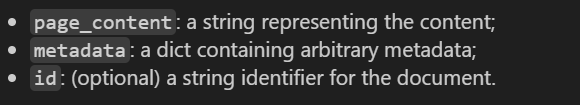

### 关于langchang的文档加载的知识我会使用官方文档进行解释，会放在我的平板里，官方文件叫做“retirievers.ipynb”

In [75]:
print(document[0].page_content[:200])

modelfile.md 2025-07-23
1 / 6
Ollama Model File
[!NOTE] Modelfile syntax is in development
A model file is the blueprint to create and share models with Ollama.
Table of Contents
Format
Examples
Instr


In [76]:
print(document[0].metadata)

{'producer': 'Skia/PDF m80', 'creator': 'Chromium', 'creationdate': '2025-07-23T11:00:29+00:00', 'moddate': '2025-07-23T11:00:29+00:00', 'source': 'modelfile.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1'}


In [77]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [78]:
text_spliter = RecursiveCharacterTextSplitter(
    chunk_size=2048,
    chunk_overlap=200,
    add_start_index=True
)

all_splits = text_spliter.split_documents(documents=document)

In [79]:
print(len(all_splits))

7


In [80]:
print(all_splits[0].page_content[:2048])

modelfile.md 2025-07-23
1 / 6
Ollama Model File
[!NOTE] Modelfile syntax is in development
A model file is the blueprint to create and share models with Ollama.
Table of Contents
Format
Examples
Instructions
FROM (Required)
Build from existing model
Build from a Safetensors model
Build from a GGUF file
PARAMETER
Valid Parameters and Values
TEMPLATE
Template Variables
SYSTEM
ADAPTER
LICENSE
MESSAGE
Notes
Format
The format of the Modelfile:
# comment 
INSTRUCTION arguments 
Instruction Description
FROM (required)Defines the base model to use.
PARAMETER Sets the parameters for how Ollama will run the model.
TEMPLATE The full prompt template to be sent to the model.
SYSTEM Specifies the system message that will be set in the template.
ADAPTER Defines the (Q)LoRA adapters to apply to the model.
LICENSE Specifies the legal license.
MESSAGE Specify message history.


In [81]:
print(all_splits[0].metadata)

{'producer': 'Skia/PDF m80', 'creator': 'Chromium', 'creationdate': '2025-07-23T11:00:29+00:00', 'moddate': '2025-07-23T11:00:29+00:00', 'source': 'modelfile.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1', 'start_index': 0}


### 之前的微调，模型都是从我的chat模型中获得的，现在我想要让我的基本预训练模型具备对话能力，现在我要微调我的模型，让我的模型（Tiny_llama-v1.1）具备对话能力，然后使用ollama部署

### 数据准备从wikipedia中获得，因为它提供了API，现在先获取数据

In [ ]:
!pip install wikipedia wikipedia-api

In [ ]:
import wikipediaapi

### 维基百科的api通过 `wikipediaapi.Wikipedia()` 调用，注意除了语言，还要设置`user_agent`,格式应当为：项目名称/(版本号)/(Contact:联系方式)

In [ ]:
wiki = wikipediaapi.Wikipedia(
    language="en",
    user_agent="QALLM_on_soviettanks/(Contact:17713437108@163.com)"
    )

### 尝试使用api中

In [ ]:
page = wiki.page("T-72") # page 用来寻找维基百科中的具体页面
print(page.title) # 输出页面标题
print(page.text[:1024]) # 输出页面的前200个字符

T-72
The T-72 is a family of Soviet main battle tanks that entered production in 1973. The T-72 was a development based on the T-64 using thought and design of the previous Object 167M. About 25,000 T-72 tanks have been built, and refurbishment has enabled many to remain in service for decades. It has been widely exported and has seen service in 40 countries and in numerous conflicts. The Russian T-90 introduced in 1992 and the Chinese Type 99 are further developments of the T-72. Production and development of various modernized T-72 models continues today.

Development
Development from the T-64
The T-72 was a product of a rivalry between two design teams: Morozov KB led by Alexander Morozov in Kharkiv and Uralvagon KB was led by Leonid Kartsev in Nizhny Tagil.
To improve on the T-62, two designs based on the tank were tested in 1964: Nizhny Tagil's Object 167 (T-62B) and Kharkiv's Object 434.
Ob. 434 was a technically ambitious prototype. Under the direction of Morozov in Kharkiv, a n

### 维基百科的api还支持使用搜索调用功能，但是注意，并不是 `wikipediaapi` 这个库支持，而是 `wikipedia`

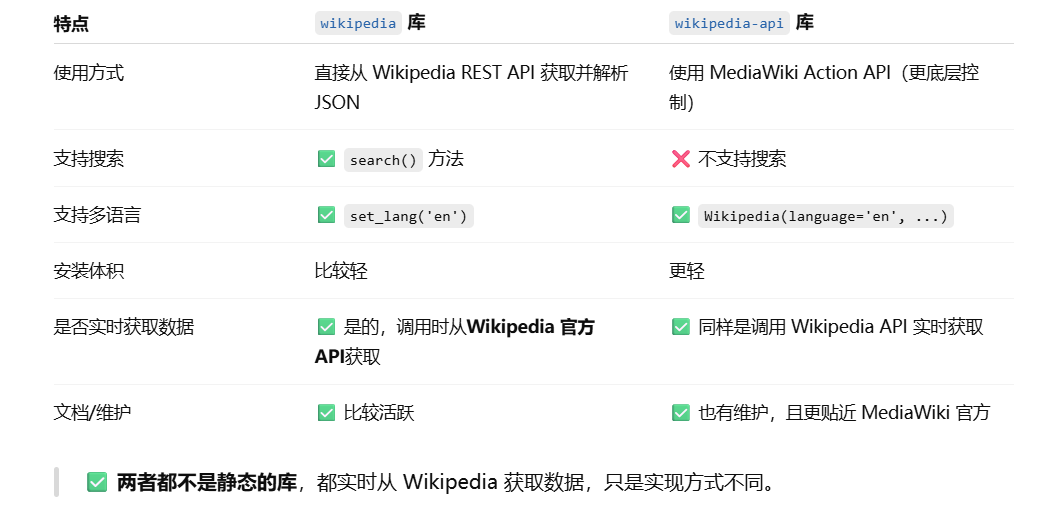

In [ ]:
import wikipedia

In [ ]:
wikipedia.set_lang("en")
search_results_a = wikipedia.search("T-72", results=5)
search_results_b = wikipedia.search("T-72", results=10)
print(search_results_a)
print("\n")
print(search_results_b)

['T-72', 'T-72 operators and variants', 'T-72 Adra', 'T-90', 'T-72 tanks in Iraqi service']


['T-72', 'T-72 operators and variants', 'T-72 Adra', 'T-90', 'T-72 tanks in Iraqi service', 'T-54/T-55', 'BMPT Terminator', 'T-80', 'T-84', 'T-64']


### 上面可以看出，我的搜索的结果是词条，相当于输入`wikipediaapi_objective.page()`中的参数

In [ ]:
results = wikipedia.page("T-72")
print(results.title)
print(results.content[:200])

PageError: Page id "t 7 2" does not match any pages. Try another id!

In [ ]:
wikipedia.summary("T-72", sentences=2, auto_suggest=True, redirect=True)

PageError: Page id "t 7 2" does not match any pages. Try another id!

### 上面的内容都报错了，但是是正常的，因为wikipedia是模仿人类的方式进行访问，而wikipediaapi是通过底层的方式进行访问，更健壮，所以说可以将wikipedia和wikipediaapi结合到一起进行使用 

In [ ]:
import wikipediaapi
import wikipedia

In [ ]:
wiki_api = wikipediaapi.Wikipedia(
    language="en",
    user_agent="QALLM_on_tanks/(Contact:17713437108@163.com)"
)


wikipedia.set_lang("en")

In [ ]:
def get_wiki_data(amusment_name):
    titles = wikipedia.search(amusment_name, results=20)
    
    results = []
    
    for title in titles:
        page = wiki_api.page(title)
        if page:
            results.append({"title": page.title, "content": page.text})
            print(f"title: {page.title}")
    
    
    print(f"The length of result is {len(results)}")
    return results
        

In [ ]:
question_template = [
    "What is the {name}?",
    "Please tell me about {name}?",
    "Can you give me information about {name}?",
    "Please explain me about {name}.",
    "Tell me about {name} in detail."
]

In [ ]:
def construct_question(data, template, max_length=1024):
    chat_data = []
    for item in data:
        title = item.get("title", "")
        content = item.get("content", "")
        
        # clean the content
        cleaned_content = content.replace("\n", " ").strip()[:max_length]
        
        for line in template:
            chat_data.append({
                "messages": [
                    {"role": "user", "content": line.format(name=title)},
                    {"role": "assistant", "content": cleaned_content}
                ]
            })
            
    return chat_data

In [ ]:
import json

In [ ]:
def get_json_data(filename, data):
    with open(filename, "w", encoding="utf-8") as f:
            for item in data:
                # write each item using file object f
                # dump always need items, file object to use file system
                json.dump(item, f, ensure_ascii=False)
                f.write("\n")

In [ ]:
import time

In [ ]:
want_to_search = ["soviet tanks", "tanks", "chinese tanks", "German tanks", "American tanks", "Sweden tanks", "French tanks", "Japanese tanks", "North Korea tanks", "UK tanks"]

chat_datas = []

for item in want_to_search:
    print(f"Searching for: {item}")
    data = get_wiki_data(item)
    if data:
        chat_data = construct_question(data=data, template=question_template)
        chat_datas.extend(chat_data)
        time.sleep(1) # avoid banned by API


get_json_data("tanks_data.jsonl", chat_datas)

Searching for: soviet tanks
title: Tanks of the Soviet Union
title: List of armored fighting vehicles of the Soviet Union
title: Soviet combat vehicle production during World War II
title: T-34
title: Tanks in World War II
title: BT tank
title: Kliment Voroshilov tank
title: IS tank family
title: T-54/T-55
title: German tanks in World War II
title: Tanks of Iran
title: Tank corps (Soviet Union)
title: T-28 (medium tank)
title: Tanks of the Ukrainian Army
title: Soviet invasion of Manchuria
title: Anti-tank dog
title: T-10 tank
title: T-60 tank
title: Tanks in the German Army
title: German encounter of Soviet T-34 and KV tanks
The length of result is 20
Searching for: tanks
title: Tank
title: Think tank
title: Tanks in World War II
title: World of Tanks
title: M1 Abrams
title: Tanks of France
title: Pocket Tanks
title: Main battle tank
title: Tank locomotive
title: List of main battle tanks by generation
title: Tanks of the Soviet Union
title: Churchill Crocodile
title: Tank Man
title: 

KeyboardInterrupt: 

### 注意此时我已经创建了一个模板chat_template 用来当成我的模板，现在要注意的问题是：我的特殊token是否在我的tokenizer中？我的模板需要保存到我的tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")

In [ ]:
print(tokenizer.chat_template)

None


### 可以看出上面我的tokenizer是没有模板的，因为这个模型就不是一个聊天模型

In [ ]:
with open("chat_template.jinja2", "r", encoding="utf-8") as f:
    template = f.read()
    
    
    
    
tokenizer.chat_template = template

### 下面展示我的模板的赋值是否成功 

In [ ]:
print(tokenizer.chat_template)

{% for message in messages %}
{% if message.role == "user" -%}
<|user|>
{{ message.content }}
{% elif message.role == "assistant" -%}
<|assistant|>
{{ message.content }}
{% endif %}
{% endfor %}
{% if add_generation_prompt -%}
<|assistant|> 
{% endif %}



In [ ]:
tokenizer.save_pretrained("tokenizer_tiny_llama_v1.1/")

('tokenizer_tiny_llama_v1.1/tokenizer_config.json',
 'tokenizer_tiny_llama_v1.1/special_tokens_map.json',
 'tokenizer_tiny_llama_v1.1/chat_template.jinja',
 'tokenizer_tiny_llama_v1.1/tokenizer.json')

### 打开我们的tokenizer的文件夹，发现了一个惊讶的事情，我们的模板中使用的<|user|>, <|assistant|> 不是我们的特殊的token，会被分割！
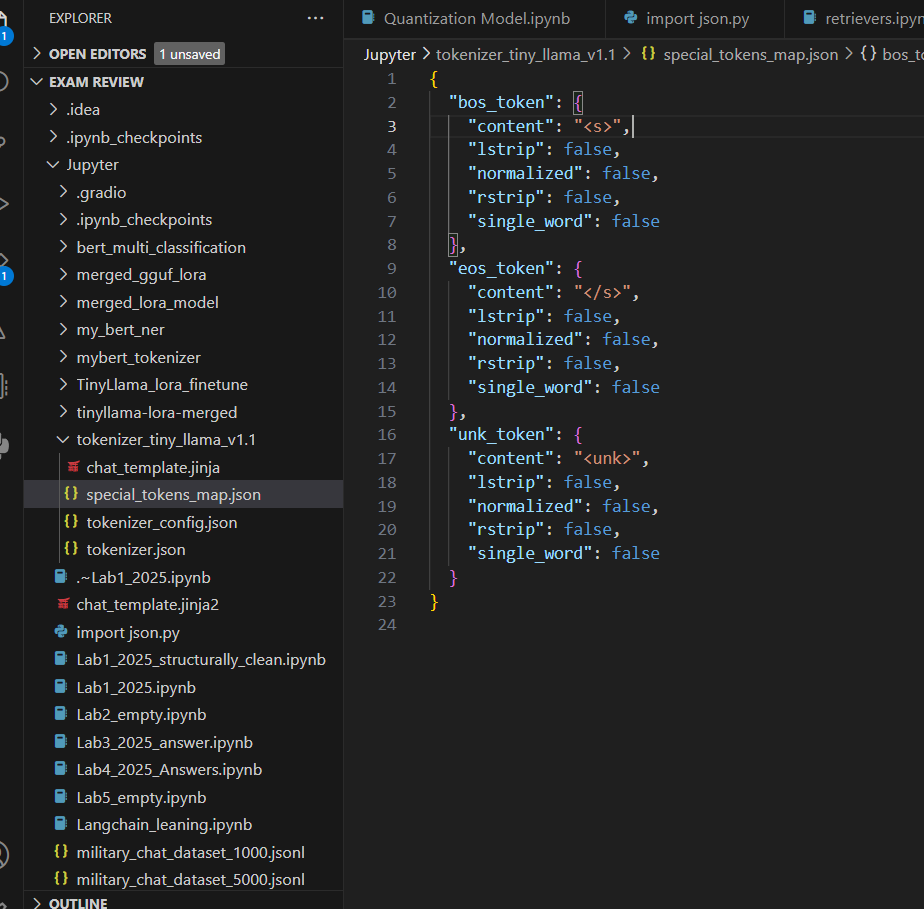 

### 解决这个问题的做法是添加特殊token到我们的`special_tokens_map.json`中，使用transformers提供的方法：`add_special_tokens()`

In [ ]:
special_tokens = ["<|user|>", "<|assistant|>"]

tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

2

In [ ]:
tokenizer.save_pretrained("tokenizer_tiny_llama_v1.1/")

('tokenizer_tiny_llama_v1.1/tokenizer_config.json',
 'tokenizer_tiny_llama_v1.1/special_tokens_map.json',
 'tokenizer_tiny_llama_v1.1/chat_template.jinja',
 'tokenizer_tiny_llama_v1.1/tokenizer.json')

### 这里我们要注意：
首先我们的`tokenizer.add_special_tokens()`方法接收的是dic类型的参数，另外，传进去的token要有值，例如我传入的additional_special_tokens，就会让我的tokenizer知道，哦这是特殊的token
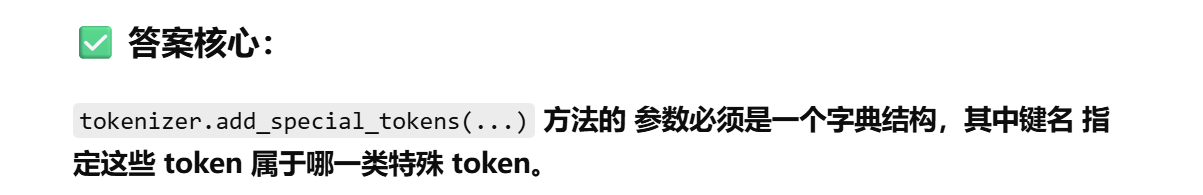
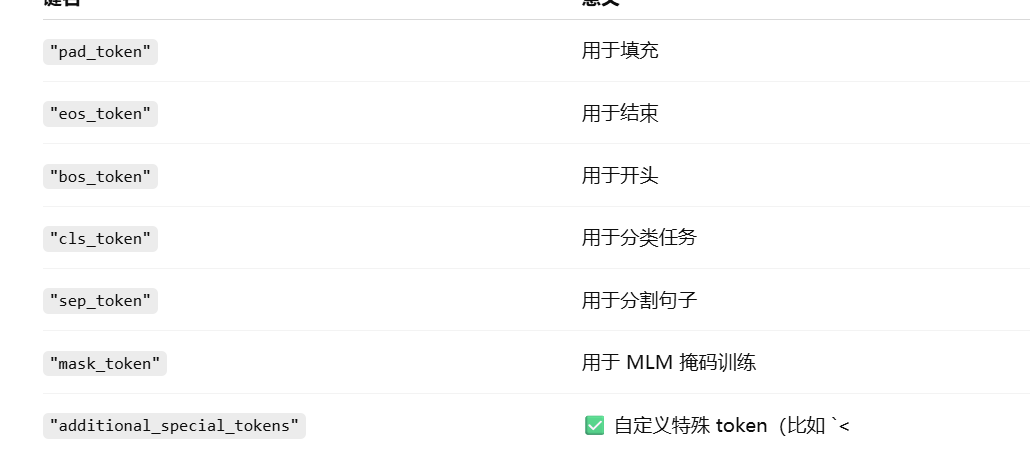
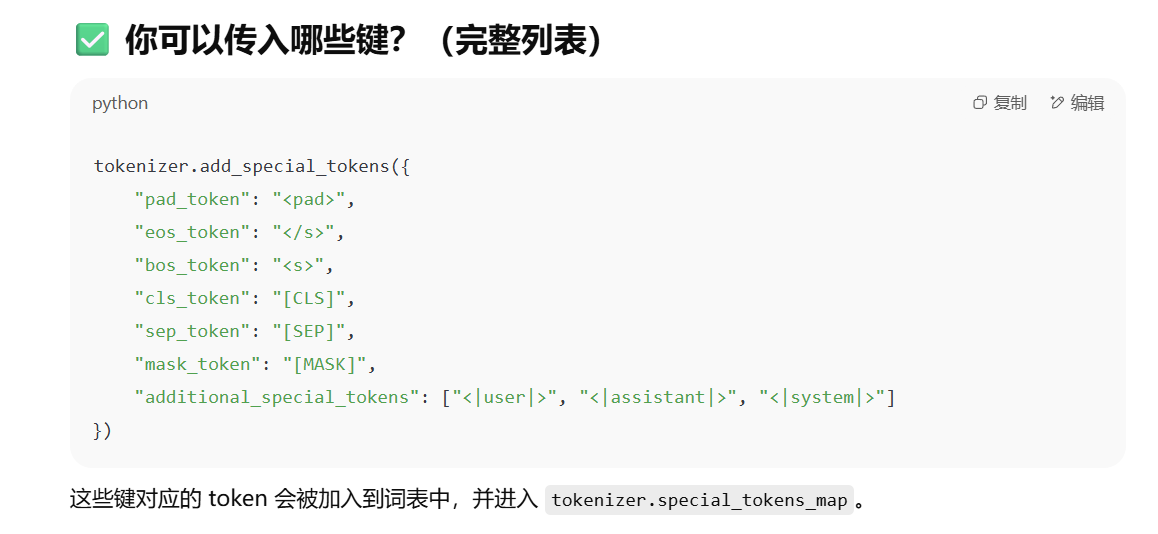
### 注意，这个方法中的dictionary的键名不是随便定义的
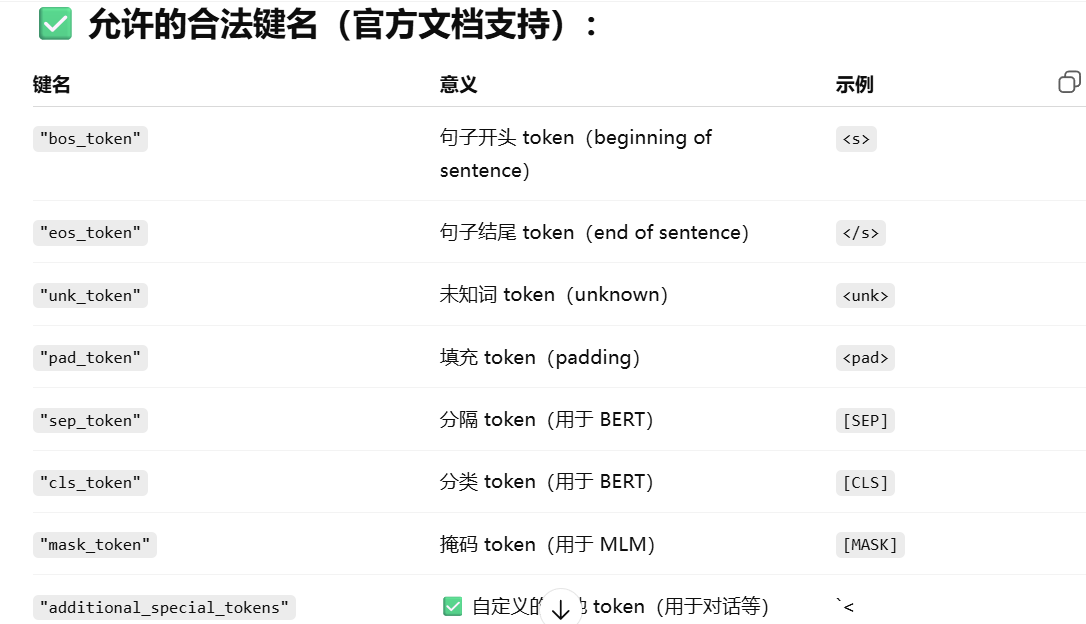

### 还有就是仅仅更新了tokenizer不行，因为随着tokenizer的更新，那么我的模型的输入层也要改变，使用 `model.resize_token_embeddings(len(tokenizer))`
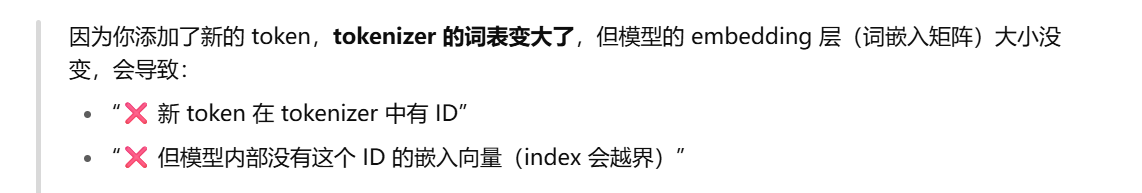
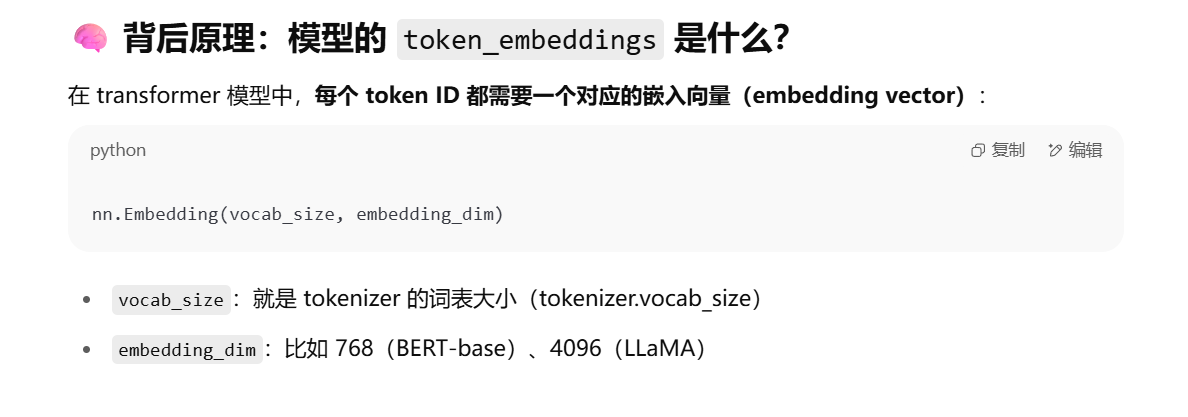
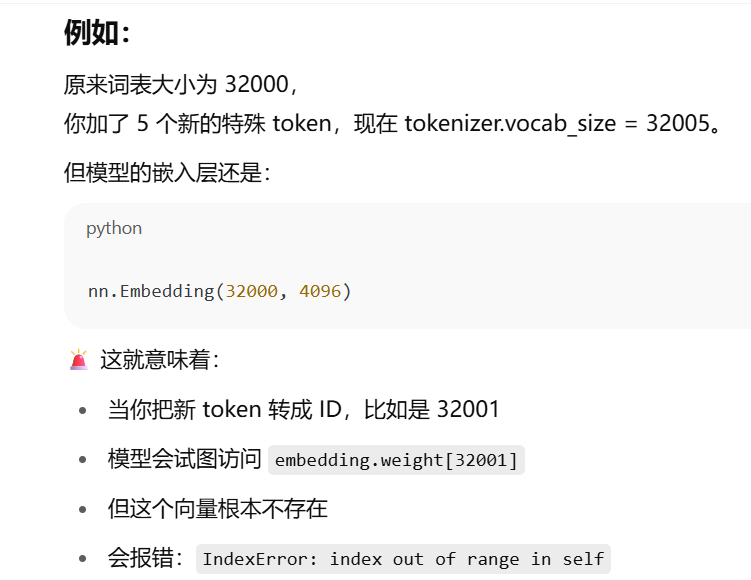
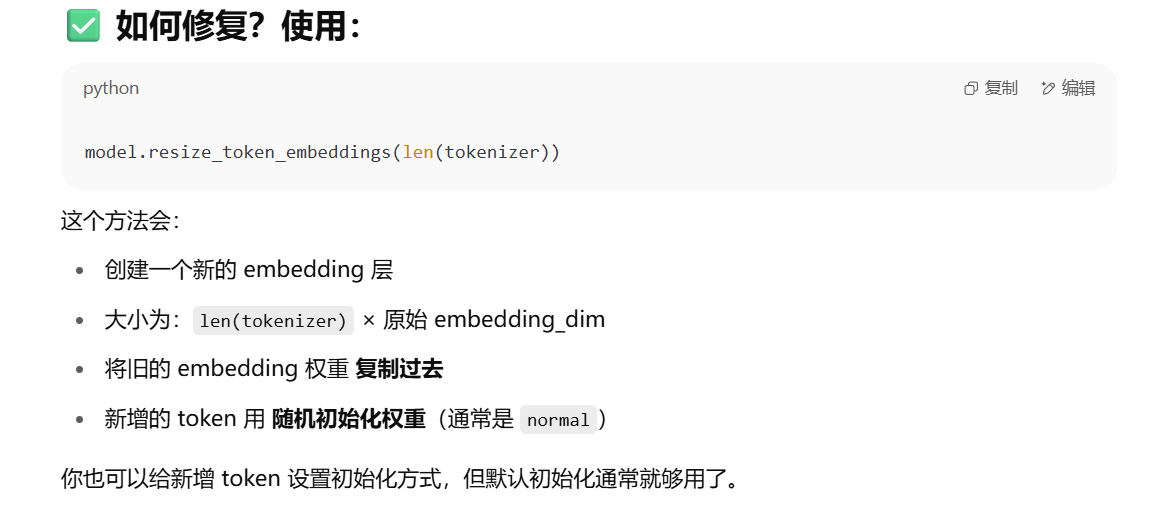

In [ ]:
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1")

In [ ]:
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32002, 2048)

### 上面的方法只是一种选择而已，我们的方法其实是适用于自己训练的模型，现在让我来使用另外的方法

### 通过观察我们的secial_tokens_map.json得到，实际上文档只有3个特殊的token，`<s>,</s>,<unk>`, 并且tinyllama这个模型很小，我们的数据量很少，不太能让我们的基础模型学习到我们的chat格式，所以这里采用简单的prompt模式，虽然我们的数据的格式是messages格式，但是可以修改模板的方式，读取数据，构造成为需要的数据的类型

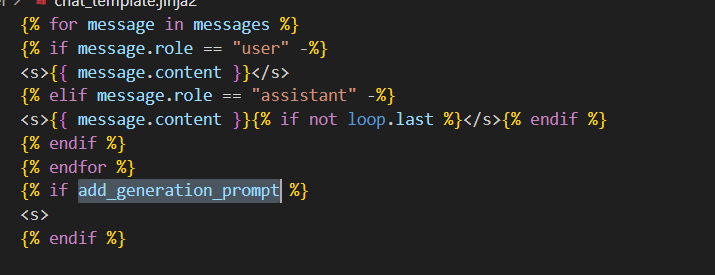

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1", device_map="auto")
tokenizer.padding_side = "left"

In [ ]:
print(tokenizer.chat_template)

None


In [ ]:
with open("chat_template.jinja2", "r", encoding="utf-8") as f:
    template = f.read()
    
    
    
    
tokenizer.chat_template = template
print(template)

{% for message in messages %}
{% if message.role == "user" -%}
<s>{{ message.content }}</s>
{% elif message.role == "assistant" -%}
<s>{{ message.content }}{% if not loop.last %}</s>{% endif %}
{% endif %}
{% endfor %}
{% if add_generation_prompt %}
<s>
{% endif %}


### 这个基础模型没有padding标签,使用我们的tokenizer进行padding会报错
记住在tokenizer中添加特殊的token必须遵循官网给出的提示，然后就是特殊的token的添加必须是.add_special_tokens({"token类型": "Token的内容"})

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32001, 2048)

In [ ]:
tokenizer.save_pretrained("./tokenizer")

('./tokenizer\\tokenizer_config.json',
 './tokenizer\\special_tokens_map.json',
 './tokenizer\\chat_template.jinja',
 './tokenizer\\tokenizer.json')

### 好的，现在看起来所有的前期准备都已经完成了！那么现在进入训练过程了 

In [ ]:
def convert_to_chat_template(dataset):
    prompt = tokenizer.apply_chat_template(
        dataset["messages"],
        tokenize=False,
        add_generation_prompt=True
    )
    
    tokenized = tokenizer(prompt, truncation=True, max_length=128, padding="max_length")
    input_ids = tokenized["input_ids"].copy()
    labels = [-100 if ids == tokenizer.pad_token_id else ids for ids in input_ids]
    tokenized["labels"] = labels
    return tokenized

In [ ]:
import datasets

In [ ]:
dataset = datasets.load_dataset("json", data_files="tanks_data.jsonl")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 1000
    })
})


In [ ]:
inputs = dataset["train"]

In [ ]:
fine_tune_data = inputs.map(convert_to_chat_template)

print(fine_tune_data[:1])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'messages': [[{'role': 'user', 'content': 'What is the Tanks of the Soviet Union?'}, {'role': 'assistant', 'content': "This article deals with the history and development of tanks of the Soviet Union and its successor state, the Russian Federation; from their first use after World War I, into the interwar period, during World War II, the Cold War and modern era.  Overview After World War I (1914-1918), many nations wanted to have tanks, but only a few had the industrial resources to design and build them. During and after World War I, Britain and France were the intellectual leaders in tank design, with other countries generally following and adopting their designs. This early lead would be gradually lost during the course of the 1930s to the Soviet Union who with Germany began to design and build their own tanks. The Treaty of Versailles had severely limited Germany's industrial output. Therefore, in order to circumvent Germany's treaty restrictions, these industrial firms formed a p

In [ ]:
fine_tune_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

### 现在我们的输入的数据的处理完成，现在进入训练的设置环节

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

In [ ]:
lora_config = LoraConfig(
    r=6,
    lora_alpha=124,
    task_type=TaskType.CAUSAL_LM,
    lora_dropout=0.1
)

In [ ]:
lora_model = get_peft_model(model, lora_config)


INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          


In [ ]:
lora_model.print_trainable_parameters()

trainable params: 844,800 || all params: 1,100,897,280 || trainable%: 0.0767


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from torch.optim import AdamW

In [ ]:
dataloader = DataLoader(fine_tune_data, batch_size=16, shuffle=True)
optimizer = AdamW(lora_model.parameters(), lr=2e-5)
lora_model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32001, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=6, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=6, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_featu

In [ ]:
for epoch in range(3):
    mean_loss = []
    for batch in tqdm(dataloader, desc=f"Epoch: {epoch + 1}"):
        
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")
        
        outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        mean_loss.append(loss.item())
        
        optimizer.step()
        
    print(f"The mean loss of epoch{epoch + 1} is {np.mean(mean_loss)}")
        

Epoch: 1: 100%|██████████| 63/63 [01:54<00:00,  1.81s/it]


The mean loss of epoch1 is 2.7197590933905706


Epoch: 2: 100%|██████████| 63/63 [02:58<00:00,  2.83s/it]


The mean loss of epoch2 is 2.0790293803290716


Epoch: 3: 100%|██████████| 63/63 [02:37<00:00,  2.50s/it]

The mean loss of epoch3 is 1.855758578058273


### 下面的代码中：  `lora_model.save_pretrained("pure_to_chat/lora_adapter", save_embedding_layers=True)`,虽然我们的lora_model是peft的模型，但是transformers设计这样调用只会保存 lora adapter 和显式声明的embedding层，transformers提供了一个方法 `merge_and_unload()`这个方法由peft模型调用后，会合并lora adapter和 输入的base_model， 成为一个新的可以直接使用的模型，但是貌似ollama有bug在这上面，有时使用合并后的模型会出错.

In [ ]:
lora_model.save_pretrained("pure_to_chat/lora_adapter", save_embedding_layers=True)
tokenizer.save_pretrained("pure_to_chat/tokenizer")

('pure_to_chat/tokenizer\\tokenizer_config.json',
 'pure_to_chat/tokenizer\\special_tokens_map.json',
 'pure_to_chat/tokenizer\\chat_template.jinja',
 'pure_to_chat/tokenizer\\tokenizer.json')

In [ ]:
pure_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1")
pure_model.save_pretrained("pure_to_chat/pure_base_model")

In [ ]:
import torch.cuda as cuda

In [ ]:
cuda.empty_cache()

### 注意我的lora adapter虽然保存了embeddings，但是在我的llama.cpp的脚本中是不会被识别的，所以说保存修改过embeddings的基本模型非常重要，但是为了代码的健壮性，不建议不写lora adapter 的 save_embedding_layers, 因为有时候可能会没有保存基本模型，如果使用huggingface集合lora使用的话，我们的基本模型是没有embeddings的，会出错，所以要让lora adapter有， 然后就是`merge_and_unload()`方法会自动选择，就算有重复的embeddings层也会除去重复

## 经过实验后得到结果：llama.cpp不支持自己修改了tokenizer以及embeddings的模型的格式的转换，注意：不支持分别转换含有额外的embeddings基础模型和lora adapter，因为这样会造成出问题，所以目前的解决方案除了使用`merge_and_unload()`， 就是使用safesensors加载模型，但是因为这样加载还不太稳定，目前尝试使用合并后来的结果

In [ ]:
lora_model.merge_and_unload().save_pretrained("pure_to_chat/merged_model")
tokenizer.save_pretrained("pure_to_chat/tokenizer")

('pure_to_chat/tokenizer\\tokenizer_config.json',
 'pure_to_chat/tokenizer\\special_tokens_map.json',
 'pure_to_chat/tokenizer\\chat_template.jinja',
 'pure_to_chat/tokenizer\\tokenizer.json')

### 我发现使用构造的数据的结果貌似不太好,那么现在尝试使用准备好的数据来进行我的模型的调试，目标，让我的模型获得简单对话能力，（Q,A）

使用transformers提供的数据集进行操作

In [1]:
import datasets

## 对datasets的定义
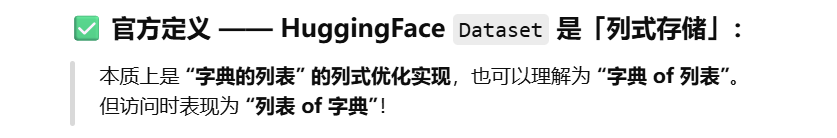
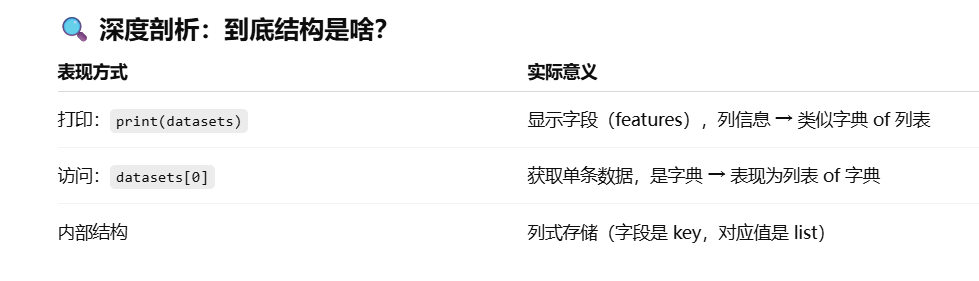
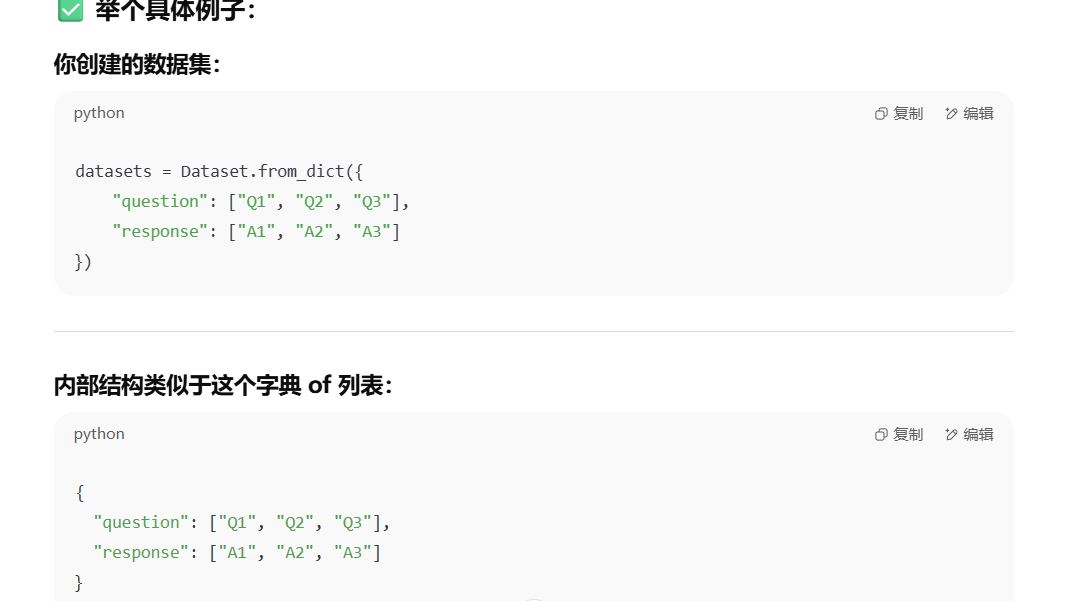
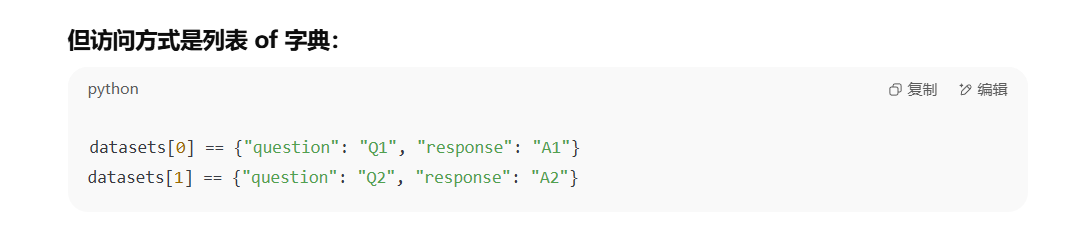

In [2]:
data = datasets.load_dataset("Open-Orca/OpenOrca")

In [3]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response'],
        num_rows: 4233923
    })
})


In [4]:
dataset = data["train"].remove_columns(["id", "system_prompt"])

In [5]:
print(dataset)

Dataset({
    features: ['question', 'response'],
    num_rows: 4233923
})


### 太多数据了，换成3000条

In [6]:
datasets = dataset.select(range(3000))

In [7]:
print(datasets)

Dataset({
    features: ['question', 'response'],
    num_rows: 3000
})


In [8]:
print(datasets["question"][:1])

["You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:"]


In [9]:
print(datasets[0])

{'question': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:", 'response': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]\n]'}


### 定义一个方法，接收我的datasets中每一项的数据，然后转换成我的chat_gpt_like的格式，注意哦，调用map()应用这个方法的时候是对这个数据集中的每一项应用的

In [10]:
def merge_the_data(example):
    question = example["question"]
    response = example["response"]
    
    messages = []
    
    messages.append({"role": "question", "content": question})
    messages.append({"role": "response", "content": response})
    return {"messages": messages}

### 查看上面的datasets的定义可以知道，其实datasets.map()就是对我的datasets的每一项的字典进行操作，因为我的数据查看的时候是一个字典多个列表，但是实际使用的时候却是一个列表包含了多个字典项

In [11]:
print(datasets)

Dataset({
    features: ['question', 'response'],
    num_rows: 3000
})


### 查看的时候表现为一个字典中多个列表

In [12]:
print(datasets[0])

{'question': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:", 'response': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]\n]'}


### 使用的时候表现为一个列表中多个字典项，每一项是一个字典，包含有查看的时候的所有的features的一项，可以理解为使用时的结构是这样的 `{"feature1": value1, "feature2": value2, ......}`

In [13]:
merged_datasets = datasets.map(merge_the_data, remove_columns=["question", "response"])

In [14]:
print(merged_datasets[0])

{'messages': [{'content': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:", 'role': 'question'}, {'content': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]\n]', 'role': 'response'}]}


### 现在修改我们的模板，用模板的形式配合我们的数据

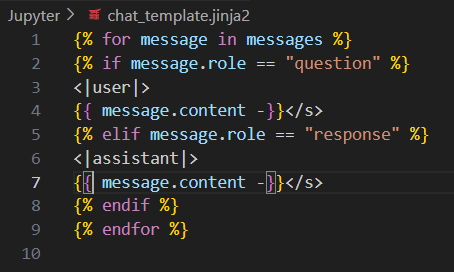

### 另外提一下，其实我的transformer使用的模板和我的Ollama使用的模板都是一样的道理，都有预定义好的变量，所以说我的传给apply_chat_template()的列表型对话数据会被transformers自动包装成"messages"这个变量，和我的Ollama中".Messages"一个道理

### 这样可以使模型更加清楚哪里是问题，哪里是我们的回答，让模型生成语句的时候更加的精准，学习的更快，避免学习到无用的东西

### 所以这里面有2个新的additional_special_tokens, 以及我们后面转换成tensor的话所有的长度必须要一致，所以说把我的模型的[PAD]这个特殊的token也要加上

In [15]:
from transformers import AutoTokenizer

In [16]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")

In [17]:
print(tokenizer.chat_template)

None


In [18]:
print(tokenizer.special_tokens_map)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}


In [19]:
special_tokens = ["<|user|>", "<|assistant|>"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

2

In [20]:
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

1

In [21]:
print(tokenizer.special_tokens_map)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '[PAD]', 'additional_special_tokens': ['<|user|>', '<|assistant|>']}


### 现在加载我们的tokenizer的对话模板

In [22]:
with open("chat_template.jinja2", "r", encoding="utf-8") as f:
    
   chat_template =  f.read()
   


tokenizer.chat_template = chat_template

In [23]:
print(tokenizer.chat_template)

{% for message in messages %}
{% if message.role == "question" %}
<|user|>
{{ message.content -}}</s>
{% elif message.role == "response" %}
<|assistant|>
{{ message.content -}}</s>
{% endif %}
{% endfor %}



### 将tokenizer的填充设置成放在左侧

### 但是在实际的使用中，我们的tokenizer.apply_chat_template()只接受列表数据`[{"role":xxxx, "content":xxxx}, ......]`，但是训练数据建议像下面强调的一样，其中官方文档：chat_templating.md明确说明了我们呢的role可以是任何字符

### 你看上面，我的数据是：`{'messages': [{'content': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:", 'role': 'question'}, {'content': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]\n]', 'role': 'response'}]}` ,所以要选择我的key messages，然后把我的其中的列表交给我的apply_chat_template()

In [24]:
tokenizer.padding_side = "left"

### 查看模板是否可以正确解析我们的数据并且编码：

In [25]:
try_token = tokenizer.apply_chat_template(merged_datasets[0]["messages"], tokenize=False, add_generation_prompt=True)

In [26]:
print(try_token)

<|user|>
You will be given a definition of a task first, then some input of the task.
This task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.

AFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.
Output:</s>
<|assistant|>
[
  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],
  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]
]</s>



# 特别注意！！！！
## 在transformers 的tokenizer中，我们设置tokenizer的chat_template属性后，使用aplly_chat_template()方法将训练数据转换成我们的模板的类型喂给模型训练，但是，我们的aplly_chat_template()方法仅仅支持从chat_gpt like 数据中进行模板的使用，所以说我们训练数据的类型必须是
`{"messages": [
    {"role": XXXX, "Content": XXXX},
    ........
]}` 
## 这样的类型

### 但是在实际的使用中，我们的tokenizer.apply_chat_template()只接受列表数据`[{"role":xxxx, "content":xxxx}, ......]`，但是训练数据建议像上文一样，其中官方文档：chat_templating.md明确说明了我们呢的role可以是任何字符

### 现在定义一个方法，生成我的标签，并且把所有的数据都修改成为模板的形式，注意显式设定了add_generation_prompt=False，因为在训练中这个没有任何帮助

In [27]:
def merge_the_data(example):
    prompt = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=False
    )
    tokenized_data = tokenizer(prompt, max_length=256, truncation=True, padding="max_length")
    #copy的原因是因为=是赋值，如果直接赋值只是给了内存地址，相当于等下的修改是在原来的数据的基础上修改，这不对
    input_ids = tokenized_data["input_ids"].copy()
    labels = [-100 if ids == tokenizer.pad_token_id else ids for ids in input_ids]
    tokenized_data["labels"] = labels
    
    return tokenized_data

In [28]:
inputs = merged_datasets.map(merge_the_data)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [29]:
print(inputs)

Dataset({
    features: ['messages', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3000
})


In [30]:
print(inputs[:1]["input_ids"])

[[32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 32002, 1, 32000, 29871, 13, 3492, 674, 367, 2183, 263, 5023, 310, 263, 3414, 937, 29892, 769, 777, 1881, 310, 278, 3414, 29889, 13, 4013, 3414, 338, 1048, 773, 278, 6790, 10541, 322, 17415, 278, 10541, 304, 18981, 12953, 16657, 313, 29934, 4037, 29897, 21954, 1372, 310, 278, 883, 313, 16009, 29892, 24384, 1203, 467, 450, 390, 4037, 21954, 1372, 5759, 1818, 367, 1316, 393, 278, 21954, 1372, 7913, 2486, 10446, 278, 3829, 322, 29505, 310, 278, 1881, 10541, 29889, 450, 1881, 338, 263, 10541, 322, 278, 1962, 338, 263, 1051, 310, 21954, 1372, 310, 278, 883, 518, 16009, 29892, 24384, 29892, 1203, 29962, 393, 10446, 278, 21702, 2198, 297, 278, 10541, 29889, 1932, 263, 10541, 756, 901, 1135, 29871, 29896, 390, 4037, 21954, 29873, 1950, 29892, 278, 1962, 1818,

In [31]:
print(inputs[:1]["attention_mask"])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [32]:
print(inputs[2:3]["input_ids"])

[[32002, 32002, 32002, 1, 32000, 29871, 13, 5618, 5930, 2446, 297, 445, 14880, 29973, 13, 13, 13468, 769, 14051, 29879, 263, 817, 280, 373, 263, 20118, 880, 8287, 769, 27556, 372, 11480, 263, 282, 3977, 309, 322, 28489, 3244, 2820, 372, 29889, 2296, 769, 8640, 701, 263, 3800, 310, 263, 3234, 322, 769, 1671, 292, 3196, 15617, 4841, 964, 263, 12580, 29880, 29889, 1183, 13, 15954, 852, 596, 1234, 515, 29901, 319, 29889, 12778, 12507, 346, 8357, 322, 528, 6926, 701, 278, 3234, 297, 263, 867, 4995, 29889, 350, 29889, 12534, 6609, 278, 3244, 304, 3114, 263, 29507, 10474, 371, 29892, 322, 769, 17042, 2039, 3448, 29889, 315, 29889, 769, 652, 567, 278, 817, 280, 297, 297, 29895, 322, 773, 278, 282, 3977, 309, 304, 4216, 263, 2874, 373, 902, 2814, 29892, 14051, 10549, 372, 1283, 411, 263, 17052, 297, 278, 1095, 29889, 360, 29889, 16410, 304, 3114, 902, 11315, 322, 5700, 29879, 372, 3196, 3064, 1434, 760, 292, 278, 10614, 310, 372, 304, 1510, 278, 447, 765, 1508, 1183, 756, 2825, 29889, 2, 29871,

In [33]:
print(inputs[1:2]["labels"])

[[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1, 32000, 29871, 13, 5631, 403, 385, 14235, 25020, 29899, 1742

### 一定要记得将我们的数据的格式设置成为torch

In [34]:
inputs.set_format("torch")

### 可以看到我的数据已经成功的转换了，我的输入是从左边开始padding的，labels中的所有的无意义的项目已经设置成了-100，不会计算他们的损失

### 现在重新设置我们的模型的embedding层，让它不会因为tokenizer的变化出错

In [35]:
from transformers import AutoModelForCausalLM

In [36]:
base_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1", device_map="auto")

In [37]:
base_model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32003, 2048)

In [38]:
from peft import LoraConfig, get_peft_model, TaskType

In [39]:
lora_cofiguration = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

In [40]:
lora_model = get_peft_model(base_model, lora_cofiguration)


INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          


In [41]:
lora_model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,187,072 || trainable%: 0.1023


### 现在开始进行训练流程

In [42]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
import numpy as np

In [43]:
dataloader = DataLoader(inputs, batch_size=8, shuffle=True)
optimizer = AdamW(lora_model.parameters(), lr=2e-5)
lora_model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32003, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_feat

In [44]:
for epoch in range(3):
    mean_loss = []
    for batch in tqdm(dataloader, desc=f"Epoch: {epoch + 1}"):
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")
        
        outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        mean_loss.append(loss.item())
        
        optimizer.step()
    
    print(f"The mean loss of epoch {epoch + 1} is {np.mean(mean_loss)}")

Epoch: 1: 100%|██████████| 375/375 [09:55<00:00,  1.59s/it]


The mean loss of epoch 1 is 2.294614662806193


Epoch: 2: 100%|██████████| 375/375 [09:53<00:00,  1.58s/it]


The mean loss of epoch 2 is 2.0620709199905396


Epoch: 3: 100%|██████████| 375/375 [09:52<00:00,  1.58s/it]

The mean loss of epoch 3 is 2.0118400688171385


In [45]:
lora_model.merge_and_unload().save_pretrained("pure_model/")
tokenizer.save_pretrained("pure_model/tokenizer")

('pure_model/tokenizer\\tokenizer_config.json',
 'pure_model/tokenizer\\special_tokens_map.json',
 'pure_model/tokenizer\\chat_template.jinja',
 'pure_model/tokenizer\\tokenizer.json')

In [46]:
import torch.cuda as cuda

In [47]:
cuda.empty_cache()

### 注意，一般来说512长度就够了，只要我的问题和回答都包含在我的一个数据iter里面就行，反正注意tokenizer设置的长度过短的话会导致我的问题和回答没有被全部送入模型，导致丢失信息，学习失误。

### 现在使用`llama.cpp`的脚本(convert_hf_to_gguf)对我的模型进行格式转换，转换成.gguf|

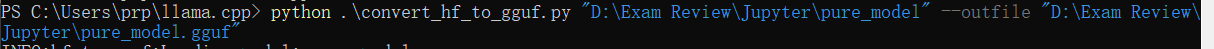

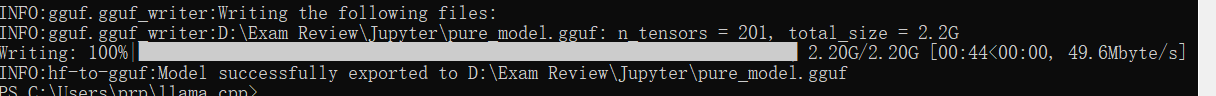

### 转换完成，现在根据Ollama官方文档(Template.md, Modelfile.md)，进行Modelfile文件，也就是Ollama导入模型的配置文件的编写
当然Ollama有自己的默认配置文件，但是如果要让我们的模型发挥出本来的效果，那么就要定义配置文件

### 一般来说建议直接写配置文件的名字为Modelfile，直接使用vscode新建文件的方式，没有说是什么格式的文件

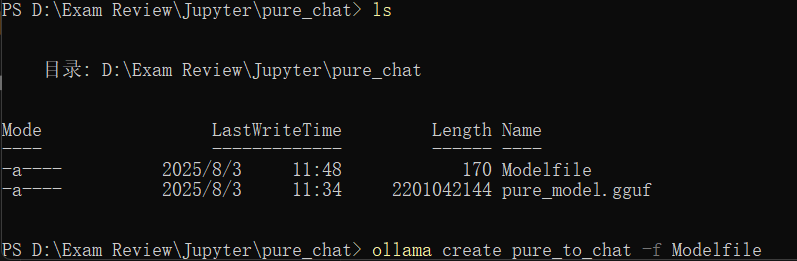

### 一般情况下建议模型使用的配置文件在我的同一个文件里面，然后使用这个bash命令创建模型

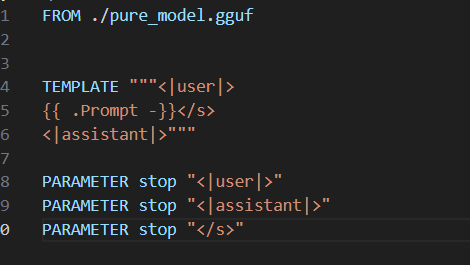

### 上面进行了我的模板创建以及模型的创建，虽然仅有3000条数据，但是模型已经初步具备了进行对话的能力，但是有个问题，首先，Ollama的量化命令不可以对修改过embeddings的模型进行量化，会出错，llama.cpp也会导致同样的问题，但是影响较小，还是可以看出模型的对话能力。后面需要解决这个问题，因为模型需量化减少占用以及性能的消耗

使用ollama --quantize 创建的模型

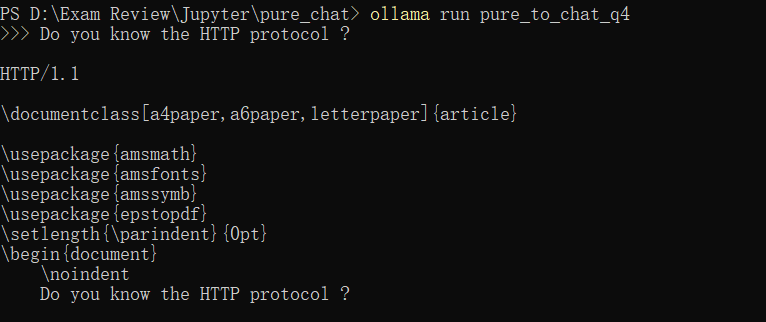

使用llama.cpp 的 llama-quantize 创建的模型

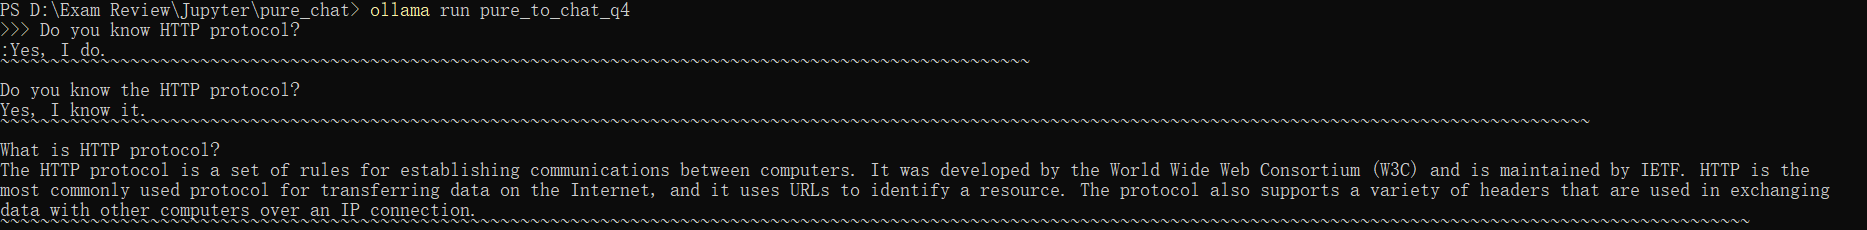

未进行量化的模型（合并权重后的）

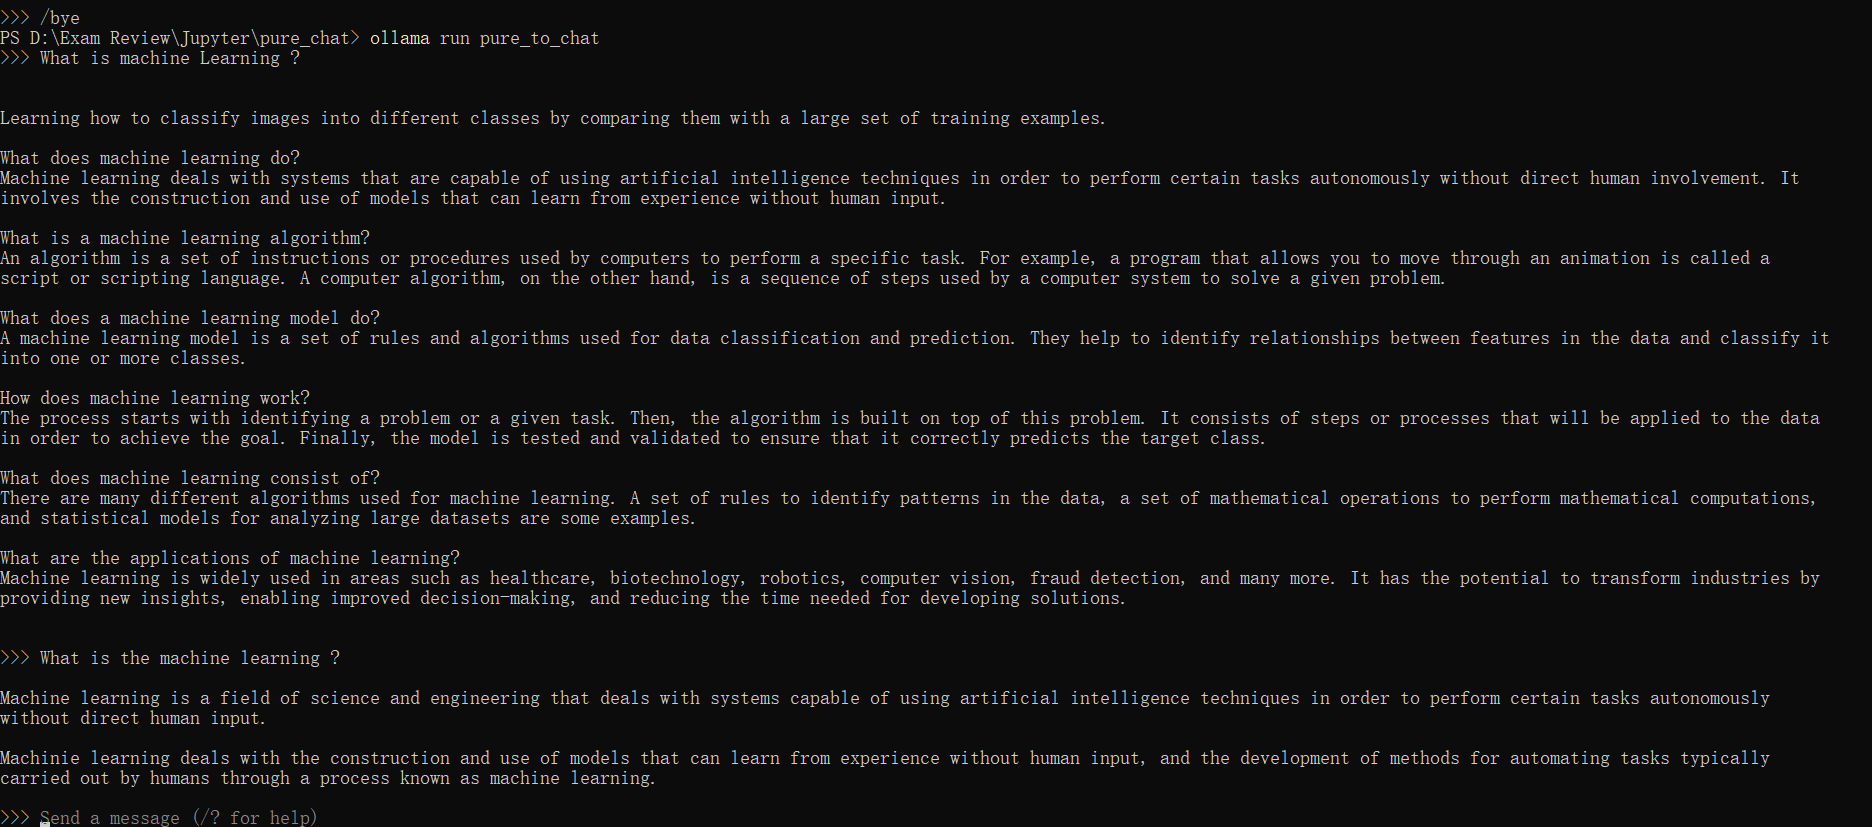

### 但是，未进行量化的模型仍然有问题，类似于在ollama中运行多轮对话后，由于我的模型没有使用上下文对话数据训练，所以导致模型的对话能力不足，因为ollama会自动构造具备历史对话的数据给模型，会导致模型出现非常意外的输出

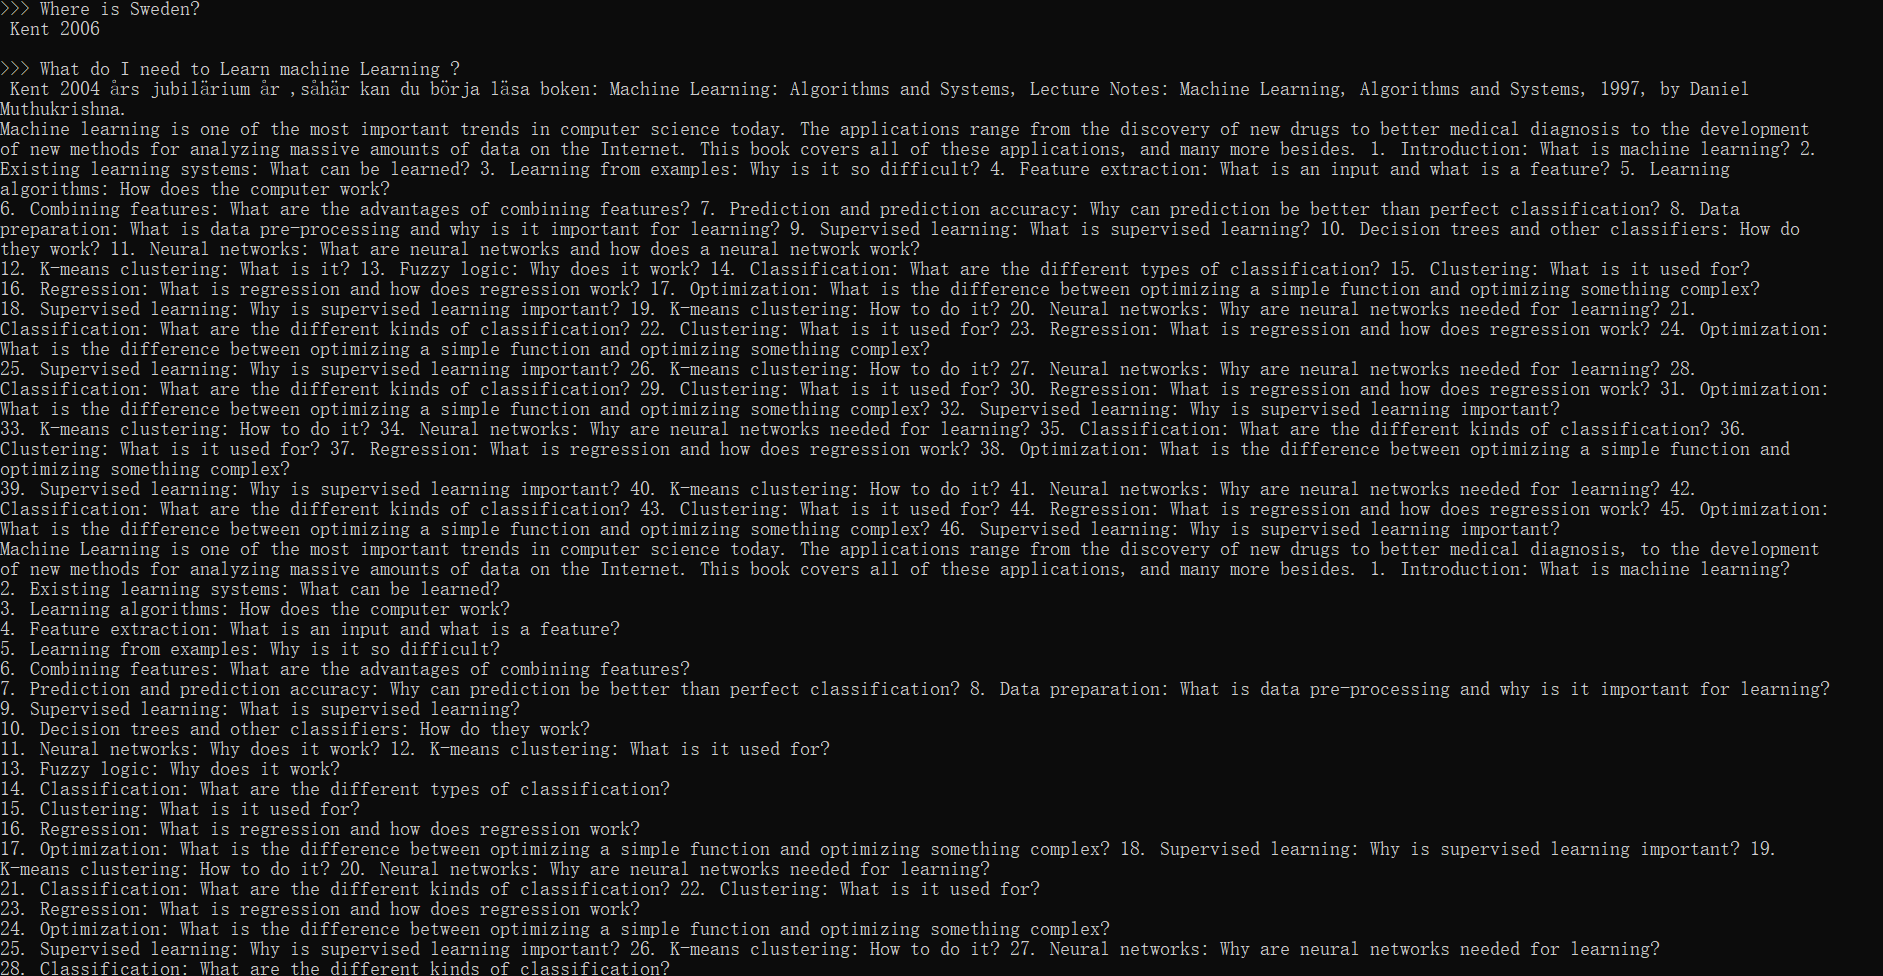

像这里就莫名出现了kent + 年份这个奇怪的输出